![Py4Eng](../logo.png)

# Finetuning pretrained model
## Yoav Ram

This notebook shows a simple, step-by-step finetuning workflow using a pretrained [EfficientNetV2](https://arxiv.org/pdf/2104.00298) backbone (from `timm`) and PyTorch. The target dataset is the [Hyena ID 2022](https://lila.science/datasets/hyena-id-2022/) dataset (3104 photos, 256 individuals) — the task is per-individual classification.

We will load the pretrained model using [`timm`](https://timm.fast.ai), a collection of state-of-the-art computer vision models. Install it with `pip install timm`.

In [1]:
%matplotlib inline
import os
import shutil
from collections import Counter
import tarfile
import urllib.request
import random
from tqdm import tqdm
from pathlib import Path
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import timm
from sklearn.model_selection import StratifiedShuffleSplit

print('torch', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print('Device:', device)

torch 2.7.1
Device: mps


# Data

We Download the [Hyena ID 2022 dataset](https://lila.science/datasets/hyena-id-2022/) and extract to `data/hyena`. 

In [2]:
url = "http://us-west-2.opendata.source.coop.s3.amazonaws.com/agentmorris/lila-wildlife/wild-me/hyena.coco.tar.gz"
out_path = '../data/hyena.coco.tar.gz'
extract_dir = '../data/hyena'
chunk = 1024 * 1024

os.makedirs(os.path.dirname(out_path), exist_ok=True)

In [3]:
if not os.path.exists(extract_dir):
    if not os.path.exists(out_path):
        print(f'Downloading {url} to {out_path}')
        with urllib.request.urlopen(url) as r, open(out_path, 'wb') as f:
            total = r.getheader('Content-Length')
            total = int(total) if total else None
            with tqdm(total=total, unit='B', unit_scale=True, desc='download') as p:
                while True:
                    data = r.read(chunk)
                    if not data:
                        break
                    f.write(data)
                    p.update(len(data))
    else:
        print(f'File {out_path} already exists, skipping download.')

    print(f"Extracting {out_path}")
    with tarfile.open(out_path, 'r:gz') as t:
        os.makedirs(extract_dir, exist_ok=True)
        t.extractall(path=extract_dir)
else:
    print(f'Extraction directory already exists, skipping extraction.')

Extraction directory already exists, skipping extraction.



The metadata is in `../data/hyena/hyena.coco/annotations/instances_train2022.json`, which contains the bounding box of the individuals in the images, as well as their the identities.

Load COCO-style annotations and build mapping from filename to identity.

In [4]:
with open('../data/hyena/hyena.coco/annotations/instances_train2022.json', 'r') as f:
    metadata = json.load(f)
bboxes = {a['image_id']: a['bbox'] for a in metadata['annotations']}

All the hyena images are now in `../data/hyena/hyena.coco/images/train2022` folder (`test2022` and `val2022` are empty). Image filenames are just the image running number.

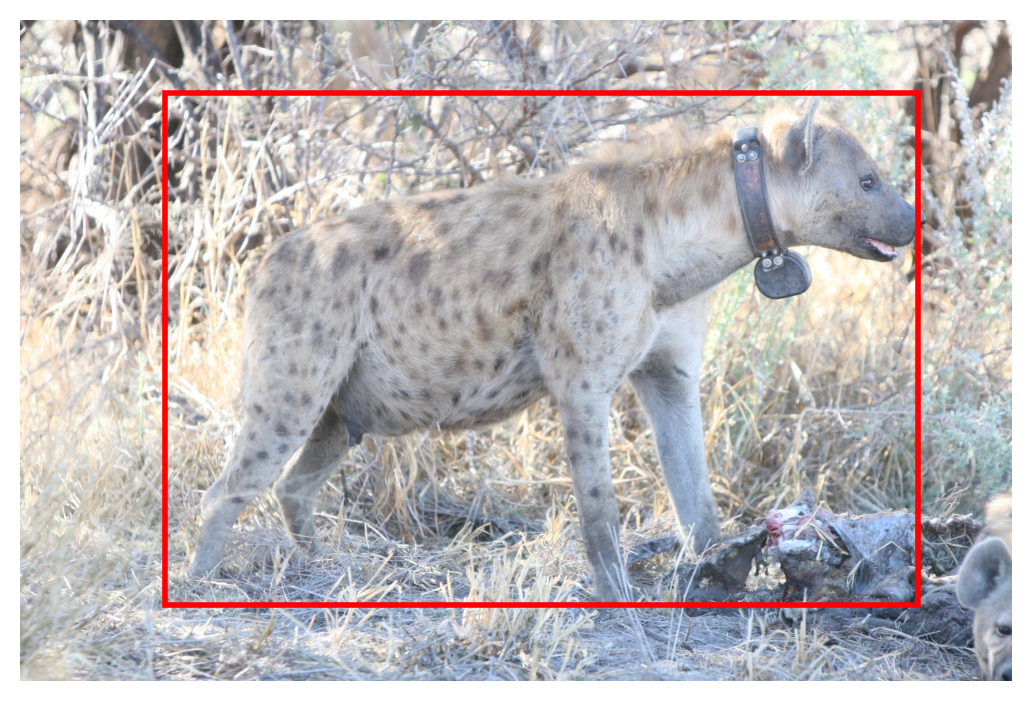

In [5]:
path_template = '../data/hyena/hyena.coco/images/train2022/{:012d}.jpg'

def plot_image(image_id, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    path = path_template.format(image_id)
    image = Image.open(path)    
    ax.imshow(image)
    bbox = bboxes[image_id]
    x, y, w, h = bbox  # Top-Left X, Top-Left Y, Width, Height
    rect = plt.Rectangle((x, y), w, h, fill=False, color='red', lw=2)
    ax.add_patch(rect)
    ax.axis('off')
    return ax

plot_image(np.random.randint(1, len(bboxes)+1));

Now we get the labels -- individual names.

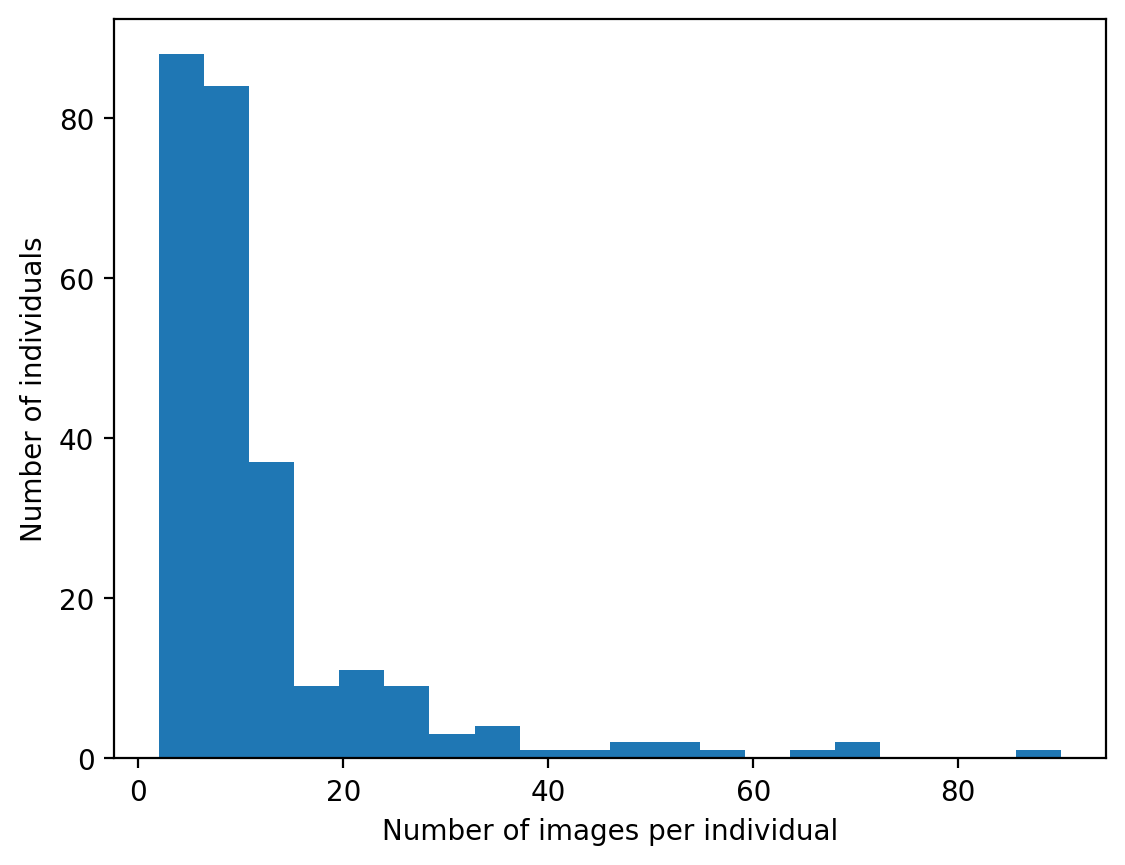

In [6]:
img2name = {a['image_id']: a['name'] for a in metadata['annotations']}
img_ids = np.array(list(img2name.keys()))

counter = Counter(img2name.values())
plt.hist(counter.values(), 20)
plt.xlabel('Number of images per individual')
plt.ylabel('Number of individuals');

Map names to integers and back.

In [7]:
name2id = {k:i for i,k in enumerate(counter.keys())}
int2name = {i:k for k,i in name2id.items()}
labels = np.array([name2id[img2name[img]] for img in img_ids])
n_classes = int(labels.max() + 1)
print("Number of classes:", n_classes)

Number of classes: 256


Split to train and test sets by defining the indexes that go to either set.

In [8]:
rng = np.random.default_rng(23)
# Use a stratified split so each individual is represented in train and val
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=23)
train_idx, val_idx = next(sss.split(img_ids, labels))
print("Number of train samples {}\nNumber of validation samples {}".format(len(train_idx), len(val_idx)))

Number of train samples 2793
Number of validation samples 311


We now define a dataset class that takes image identifiers and their corresponding labels and on each iteration loads and returns an image and its label.

In [9]:
class HyenaDataset(Dataset):    
    def __init__(self, img_ids, labels, transform=None):
        assert len(img_ids) == len(labels)
        self.img_ids = img_ids
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        image_id = self.img_ids[idx]
        label = self.labels[idx]
        path = path_template.format(image_id)
        image = Image.open(path).convert('RGB')
        # crop to bbox
        bbox = bboxes[image_id]
        x, y, w, h = bbox
        image = image.crop((x, y, x + w, y + h))
        if self.transform:
            image = self.transform(image)
        return image, label
    

Definte the image transforms: resize to the image size suitable for the model, convert to PyTorch tensor, and normalize colors. For the training transforms, we also augment the data using horizontal flips.

In [10]:
img_size = 224

val_transforms = T.Compose([
    T.Resize((img_size, img_size)),
    # T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_transforms = T.Compose([
    # stronger augmentation to improve generalization
    T.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # RandomErasing operates on tensors (helps robustness)
    T.RandomErasing(p=0.25, scale=(0.02, 0.25), ratio=(0.3, 3.3))
])

Now we create the datasets and data loaders.

In [11]:
batch_size = 32

train_ds = HyenaDataset(img_ids=img_ids[train_idx], labels=labels[train_idx], transform=train_transforms)
val_ds = HyenaDataset(img_ids=img_ids[val_idx], labels=labels[val_idx], transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

Here's how the images look like coming out of the data set.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0262864].


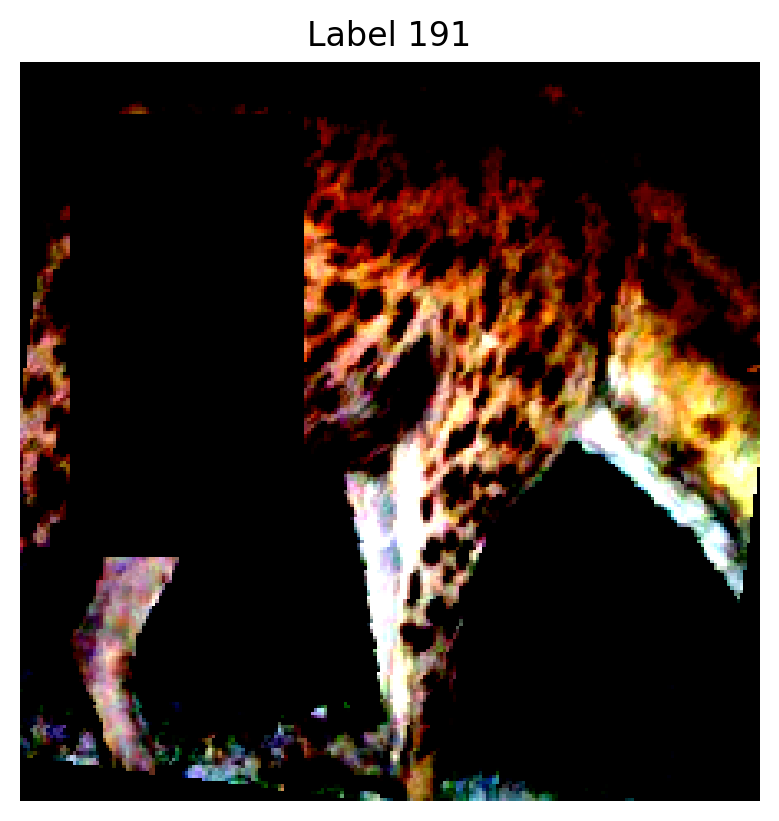

In [12]:
img, lbl = next(iter(train_ds))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title(f'Label {lbl}');

## Model
Load a pretrained **EfficientNetV2** (small) without the classifier head.
See [model card](https://huggingface.co/timm/tf_efficientnetv2_s.in21k_ft_in1k) for details.

In [13]:
# Create model (small variant for speed; change to efficientnetv2_m or _l if you want)
model_name = 'tf_efficientnetv2_s.in21k_ft_in1k'
model = timm.create_model(
    model_name, 
    pretrained=True, # 
    num_classes=0,  # remove classifier
)

Let's see the model in action. Because we specificed `num_classes=0`, the output is the last activation (that the classifier used as input during pretraining), which is called the **embedding**.

In [14]:
embedding = model(img.unsqueeze(0))
print("Embedding shape:", embedding.shape)
print(embedding)

Embedding shape: torch.Size([1, 1280])
tensor([[0.4066, 0.4486, 0.2865,  ..., 0.3314, 0.4655, 0.3424]],
       grad_fn=<ViewBackward0>)


Now reset the classifier head for hyena. It is currently an `Identity` module (because we specificed `num_classes=0`).
We reset it to be a linear module with `n_classes` (256) outputs.

In [15]:
print(model.classifier)
model.reset_classifier(num_classes=n_classes)
print(model.classifier)

Identity()
Linear(in_features=1280, out_features=256, bias=True)


We now move the model to the device (gpu/mps/cpu) and print it.

In [16]:
model.to(device)
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

### Freeze backbone and train classifier head
We freeze all parameters except the classifier parameters.

In [17]:
# Freeze everything except classifier
for name, p in model.named_parameters():
    if 'classifier' in name: # catches classifier.weight and classifier.bias
        p.requires_grad = True
        print(name, "not frozen")
    else:
        p.requires_grad = False


classifier.weight not frozen
classifier.bias not frozen


Define an Adam optimizer for the trainable parameters and a cross entropy loss function.

In [18]:
trained_params = [p for p in model.parameters() if p.requires_grad]
# Use AdamW with small weight decay to reduce overfitting
optimizer = torch.optim.AdamW(trained_params, lr=1e-3, weight_decay=1e-4)
# CrossEntropyLoss with label smoothing (reduces overconfident predictions)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

Define a function to train the model for one epoch and another function to evaluate it at the end of the epoch.

In [19]:
def train(model, data_loader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0 # for the entire epoch
    pbar = tqdm(data_loader, desc='Training', unit='batch')
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        pbar.set_postfix({'loss': f'{loss:.4f}'})
    return running_loss / len(data_loader.dataset)

def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total if total else 0.0

Now let's train just the classifier (the backbone is frozen) for 3 epochs.

In [ ]:
val_accuracies = []
n_epochs = 3
val_accuracies.append(evaluate(model, val_loader))
print(f'Before training: val_acc {val_accuracies[-1]:.4f}')
for epoch in range(n_epochs):
    loss = train(model, train_loader, optimizer, loss_fn)
    val_accuracies.append(evaluate(model, val_loader))
    print(f'Epoch {epoch+1}/{n_epochs}: loss {loss:.4f} | val_acc {val_accuracies[-1]:.4f}')

Before training: val_acc 0.0064


Training: 100%|██████████| 88/88 [00:53<00:00,  1.63batch/s, loss=3.9286]


Epoch 1/3: loss 4.6536 | val_acc 0.3087


Training: 100%|██████████| 88/88 [00:51<00:00,  1.71batch/s, loss=2.7407]


Epoch 2/3: loss 2.9543 | val_acc 0.4116


Training: 100%|██████████| 88/88 [00:51<00:00,  1.71batch/s, loss=2.5831]


Epoch 3/3: loss 2.4595 | val_acc 0.4277


### Unfreeze and finetune the whole model
Now we unfreeze all parameters and create a new optimizer for all the parameters with a lower learning rate.

In [21]:
# Unfreeze all params
for p in model.parameters():
    p.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

Now continue training the entire model (backbone+head).
This typically improves performance but takes longer - 70 min of a MacBookPro 2025 with MPS.

In [ ]:
n_epochs = 50
print(f'Before training: val_acc {val_accs[-1]:.4f}')
for epoch in range(n_epochs):
    loss = train(model, train_loader, optimizer, loss_fn)
    val_accuracies.append(evaluate(model, val_loader))
    print(f'Epoch {epoch+1}/{n_epochs}: loss {loss:.4f} | val_acc {val_accuracies[-1]:.4f}')

Training: 100%|██████████| 88/88 [01:18<00:00,  1.11batch/s, loss=2.1579]


Epoch 1/50: loss 2.0443 | val_acc 0.4727


Training: 100%|██████████| 88/88 [01:18<00:00,  1.12batch/s, loss=2.1909]


Epoch 2/50: loss 1.8966 | val_acc 0.5048


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=1.7216]


Epoch 3/50: loss 1.8008 | val_acc 0.5209


Training: 100%|██████████| 88/88 [01:20<00:00,  1.10batch/s, loss=1.8440]


Epoch 4/50: loss 1.7531 | val_acc 0.5177


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=1.5715]


Epoch 5/50: loss 1.7096 | val_acc 0.5466


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=2.1744]


Epoch 6/50: loss 1.6491 | val_acc 0.5305


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=1.9574]


Epoch 7/50: loss 1.5936 | val_acc 0.5434


Training: 100%|██████████| 88/88 [01:20<00:00,  1.10batch/s, loss=1.3632]


Epoch 8/50: loss 1.5600 | val_acc 0.5498


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.6390]


Epoch 9/50: loss 1.5231 | val_acc 0.5466


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=1.6787]


Epoch 10/50: loss 1.4914 | val_acc 0.5723


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=1.4545]


Epoch 11/50: loss 1.4540 | val_acc 0.5659


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=1.5638]


Epoch 12/50: loss 1.4391 | val_acc 0.5659


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.7011]


Epoch 13/50: loss 1.3942 | val_acc 0.5788


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.7014]


Epoch 14/50: loss 1.3847 | val_acc 0.5981


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=1.9521]


Epoch 15/50: loss 1.3715 | val_acc 0.5916


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.6694]


Epoch 16/50: loss 1.3497 | val_acc 0.5788


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.4649]


Epoch 17/50: loss 1.3256 | val_acc 0.5949


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=1.3901]


Epoch 18/50: loss 1.2966 | val_acc 0.6013


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=2.0762]


Epoch 19/50: loss 1.2924 | val_acc 0.6174


Training: 100%|██████████| 88/88 [01:21<00:00,  1.08batch/s, loss=1.6137]


Epoch 20/50: loss 1.2790 | val_acc 0.6077


Training: 100%|██████████| 88/88 [01:21<00:00,  1.09batch/s, loss=1.8055]


Epoch 21/50: loss 1.2681 | val_acc 0.6302


Training: 100%|██████████| 88/88 [01:21<00:00,  1.09batch/s, loss=1.2217]


Epoch 22/50: loss 1.2510 | val_acc 0.6238


Training: 100%|██████████| 88/88 [01:21<00:00,  1.08batch/s, loss=1.6451]


Epoch 23/50: loss 1.2306 | val_acc 0.6334


Training: 100%|██████████| 88/88 [01:21<00:00,  1.08batch/s, loss=1.4532]


Epoch 24/50: loss 1.2224 | val_acc 0.6302


Training: 100%|██████████| 88/88 [01:20<00:00,  1.10batch/s, loss=1.6617]


Epoch 25/50: loss 1.2235 | val_acc 0.6334


Training: 100%|██████████| 88/88 [01:17<00:00,  1.14batch/s, loss=1.1739]


Epoch 26/50: loss 1.2067 | val_acc 0.6431


Training: 100%|██████████| 88/88 [01:16<00:00,  1.14batch/s, loss=1.3547]


Epoch 27/50: loss 1.1921 | val_acc 0.6302


Training: 100%|██████████| 88/88 [01:17<00:00,  1.14batch/s, loss=1.1796]


Epoch 28/50: loss 1.1805 | val_acc 0.6463


Training: 100%|██████████| 88/88 [01:17<00:00,  1.14batch/s, loss=1.5355]


Epoch 29/50: loss 1.1917 | val_acc 0.6559


Training: 100%|██████████| 88/88 [01:17<00:00,  1.14batch/s, loss=1.3368]


Epoch 30/50: loss 1.1767 | val_acc 0.6656


Training: 100%|██████████| 88/88 [01:17<00:00,  1.14batch/s, loss=1.3624]


Epoch 31/50: loss 1.1656 | val_acc 0.6656


Training: 100%|██████████| 88/88 [01:17<00:00,  1.14batch/s, loss=1.2608]


Epoch 32/50: loss 1.1556 | val_acc 0.6592


Training: 100%|██████████| 88/88 [01:17<00:00,  1.14batch/s, loss=1.1635]


Epoch 33/50: loss 1.1570 | val_acc 0.6559


Training: 100%|██████████| 88/88 [01:17<00:00,  1.14batch/s, loss=1.4352]


Epoch 34/50: loss 1.1407 | val_acc 0.6624


Training: 100%|██████████| 88/88 [01:19<00:00,  1.11batch/s, loss=1.3940]


Epoch 35/50: loss 1.1388 | val_acc 0.6559


Training: 100%|██████████| 88/88 [01:20<00:00,  1.10batch/s, loss=1.1621]


Epoch 36/50: loss 1.1367 | val_acc 0.6656


Training: 100%|██████████| 88/88 [01:20<00:00,  1.09batch/s, loss=1.5020]


Epoch 37/50: loss 1.1252 | val_acc 0.6720


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.2300]


Epoch 38/50: loss 1.1193 | val_acc 0.6688


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.1341]


Epoch 39/50: loss 1.1124 | val_acc 0.6752


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.3293]


Epoch 40/50: loss 1.1154 | val_acc 0.6656


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.3814]


Epoch 41/50: loss 1.1109 | val_acc 0.6656


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.5678]


Epoch 42/50: loss 1.1029 | val_acc 0.6656


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.4033]


Epoch 43/50: loss 1.1006 | val_acc 0.6656


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.1702]


Epoch 44/50: loss 1.0916 | val_acc 0.6720


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.6599]


Epoch 45/50: loss 1.0951 | val_acc 0.6720


Training: 100%|██████████| 88/88 [01:20<00:00,  1.10batch/s, loss=1.4668]


Epoch 46/50: loss 1.0882 | val_acc 0.6720


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.2647]


Epoch 47/50: loss 1.0840 | val_acc 0.6720


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.6237]


Epoch 48/50: loss 1.0860 | val_acc 0.6688


Training: 100%|██████████| 88/88 [01:19<00:00,  1.10batch/s, loss=1.0644]


Epoch 49/50: loss 1.0795 | val_acc 0.6752


Training: 100%|██████████| 88/88 [01:20<00:00,  1.10batch/s, loss=1.2812]


Epoch 50/50: loss 1.0733 | val_acc 0.6785


In [33]:
ckpt_path = f'../data/{model_name}_finetune.pth'

torch.save({    
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),    
    'model_name': model_name,    
    'val_accuracies': val_accuracies
}, ckpt_path)
print(f'Checkpoint saved to {ckpt_path}')

Checkpoint saved to ../data/tf_efficientnetv2_s.in21k_ft_in1k_finetune.pth


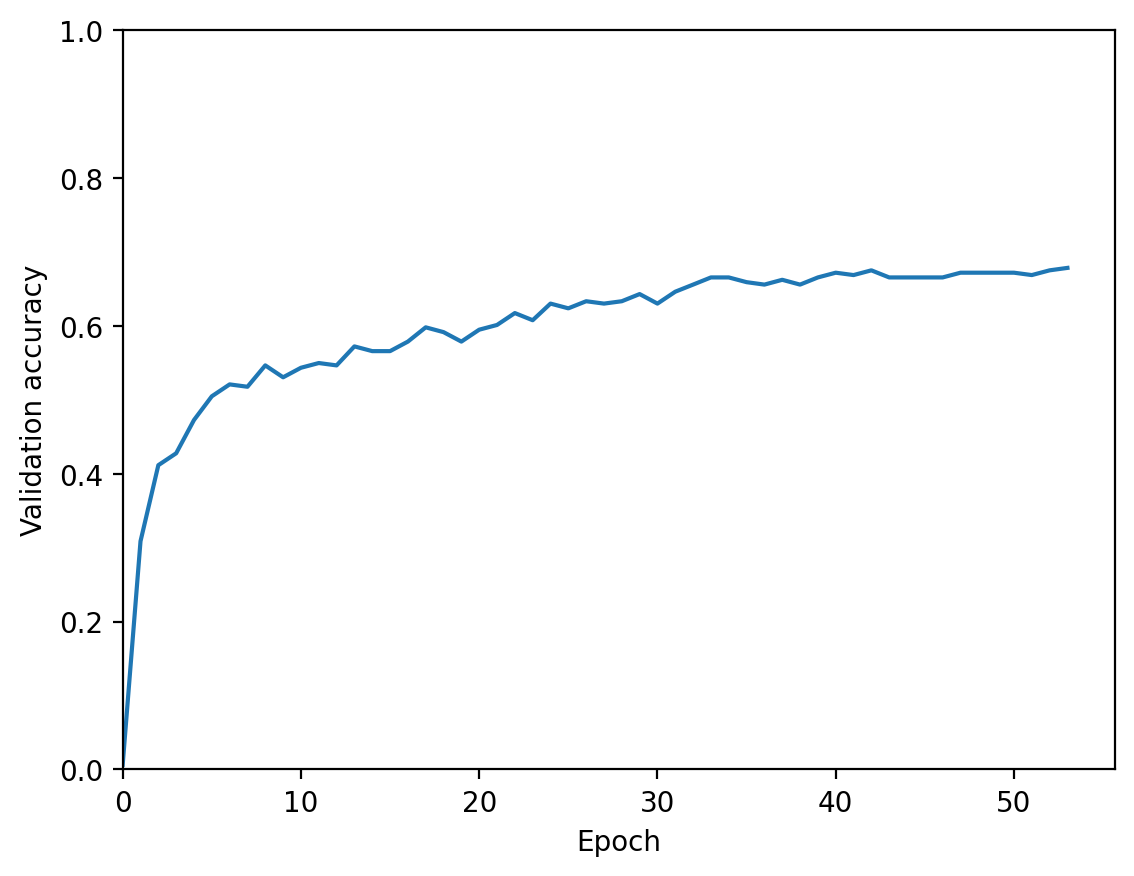

In [34]:
plt.plot(val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.ylim(0, 1)
plt.xlim(0, None);